# BTC sentiment analysis

With this script, I will download and analyze 100.000 Bitcoin (BTC) tweets from the last two weeks and perform sentiment analysis to gather market intelligence. The aim of the analysis is to understand what are people’s opinions about BTC tweets. 

Sentiment analysis consists of converting a text into a score that estimates its sentiment (e.g., demand for a given product) and can be deemed as a classification task (e.e., to extract subjectivity and sentiment polarity from text data).

Web scraping is done using snscrape (https://github.com/JustAnotherArchivist/snscrape). \
Filtering for English language is done using langdetect (https://github.com/Mimino666/langdetect). \
Sentiment analysis is done using spacytextblob (https://github.com/SamEdwardes/spacytextblob).

This script will perform the following:
1. Download data from Twitter (using snscrape)
2. Preprocess the data
3. Perform sentiment analysis (using spacytextblob)
4. Analyze & visualize the results (using nltk for preproc.)


### 1. Download data from Twitter

To download data from Twitter without using its metered API, hence without any limit on the volume of data I wish to scrape.

After loading the libraries, I will declare the search parameters. Specifically, I will be scraping 100.000 Tweets from Nov 1 2022 to yesterday (Nov 15 2022).

In [1]:
import snscrape.modules.twitter as sntwitter
import progressbar
from time import sleep
from datetime import datetime
import os
import string
import re
import statistics
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for removing non-Eng tweets:
from langdetect import detect
from langdetect import detect_langs

# for performing sentiment analysis:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# for lemmatization:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [82]:
BTC_dict = {'bitcoin': ['bitcoin since:2022-11-01 until:2022-11-15', 100000]}
output_name = 'BTC_100k_tweets_until_2022-11-15.csv'

In [83]:
today = datetime.today().strftime('%Y%m%d')[2:]+'_'
for index, BTC_name in enumerate(BTC_dict):
    print(BTC_name, '%')
    tweets_list1 = []
    bar = progressbar.ProgressBar(maxval=BTC_dict[BTC_name][1]+2, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{BTC_dict[BTC_name][0]}').get_items()): #declare a username
        bar.update(i+1)
        if i>BTC_dict[BTC_name][1]: #number of tweets you want to scrape
            break
        #print(movie_name, i, tweet)
        tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username]) #declare the attributes to be returned
    tweets_df1 = pd.DataFrame(tweets_list1, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

    tweets_df1[['Datetime', 'Text']].to_csv(output_name)
    bar.finish()

bitcoin %


[========================================================================] 100%


### 2. Preprocess the data

Let's take a look at the output file.

In [85]:
df = pd.read_csv(output_name)[['Text']]
df.tail(10)

,Text
99991,"Plot twist: \n\nCIA, FBI &amp; SEC worked toge..."
99992,@CryptoDonAlt Time to become a #bitcoin maxi.
99993,1 CORE = 1 Ethereum\n*🏆CORE Satoshi Mining🏆* h...
99994,"Bitcoin, Ethereum, Chain, and EOS Daily Price ..."
99995,"@ishtarmol @joseantonetti Jajajajajajajaja si,..."
99996,#BinanceCoin price update: $BNB\n\n#BNB $278.3...
99997,@RealJamesWoods What about #bitcoin though Jam...
99998,US Treasury Secretary and Indian Finance Minis...
99999,#bitcoin Satoshi whitepaper vision is pure and...
100000,@EntropySloth @woed051 @RayVanlandingh1 @Alice...


Let's get rid of all the @, #, and non-ascii characters, and links, and take a look again:

In [86]:
#get rid of links and hashtags
df["Text"] = df["Text"].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1 and s.find('www') == -1 and s.find('https') == -1]))

#get rid of non-ascii characters
df = df.replace(r'\W+', ' ', regex=True)
df.tail(10)

,Text
99991,Plot twist CIA FBI amp SEC worked together to ...
99992,Time to become a bitcoin maxi
99993,1 CORE 1 Ethereum CORE Satoshi Mining of Mr Sa...
99994,Bitcoin Ethereum Chain and EOS Daily Price Ana...
99995,Jajajajajajajaja si ya veo FTX quebró el bitco...
99996,BinanceCoin price update BNB BNB 278 34 USD B...
99997,What about bitcoin though James Have you learn...
99998,US Treasury Secretary and Indian Finance Minis...
99999,bitcoin Satoshi whitepaper vision is pure and...
100000,Bitcoin isn t currency But otherwise this has ...


The next preprocessing step is to remove empty and non-English tweets: training a neural netwoek to acomplish sentiment analysis is already hard with one language!

Incidentally, I also remove cells that do not contain text but for some reason do not show up to be empty when running commands such as np.where(pd.isnull(df))

First, we populate a vector describing whether the tweet is readable and in English (using the detect module of langdetect) (=1) or not (=0) and we then remove all the rows with index 0.

In [87]:
isEng = [0]*len(df)

for i in range(len(df)):
    try:
        isEngTxt = detect(df.loc[i, "Text"])
        if isEngTxt == 'en':
            isEng[i] = 1
    except:
        print(f"Row ", str(i), " has some issue: remove")

Row  183  has some issue: remove
Row  796  has some issue: remove
Row  1341  has some issue: remove
Row  1480  has some issue: remove
Row  1712  has some issue: remove
Row  1749  has some issue: remove
Row  2096  has some issue: remove
Row  2133  has some issue: remove
Row  2230  has some issue: remove
Row  2321  has some issue: remove
Row  2400  has some issue: remove
Row  2456  has some issue: remove
Row  2517  has some issue: remove
Row  2563  has some issue: remove
Row  3085  has some issue: remove
Row  3099  has some issue: remove
Row  3102  has some issue: remove
Row  3178  has some issue: remove
Row  3211  has some issue: remove
Row  3304  has some issue: remove
Row  3586  has some issue: remove
Row  4358  has some issue: remove
Row  4531  has some issue: remove
Row  4842  has some issue: remove
Row  4888  has some issue: remove
Row  5016  has some issue: remove
Row  5237  has some issue: remove
Row  5360  has some issue: remove
Row  5684  has some issue: remove
Row  5854  has s

Row  50559  has some issue: remove
Row  51543  has some issue: remove
Row  51603  has some issue: remove
Row  51688  has some issue: remove
Row  51879  has some issue: remove
Row  51991  has some issue: remove
Row  52897  has some issue: remove
Row  53909  has some issue: remove
Row  54159  has some issue: remove
Row  54589  has some issue: remove
Row  54674  has some issue: remove
Row  55605  has some issue: remove
Row  55643  has some issue: remove
Row  55649  has some issue: remove
Row  55865  has some issue: remove
Row  55926  has some issue: remove
Row  55944  has some issue: remove
Row  56353  has some issue: remove
Row  56783  has some issue: remove
Row  57327  has some issue: remove
Row  57542  has some issue: remove
Row  57558  has some issue: remove
Row  57702  has some issue: remove
Row  57930  has some issue: remove
Row  58158  has some issue: remove
Row  58247  has some issue: remove
Row  58281  has some issue: remove
Row  58671  has some issue: remove
Row  58769  has some

In [88]:
indices = [
    index for index, item in enumerate(isEng)
    if item != 0
]
df = df[df.index.isin(indices)]
df.tail(10)

### 3. Perform sentiment analysis

I am now going to apply a sentiment analysis to the cleaned data.

To install spacytextblob and download corpora: \
!pip install spacytexblob==3.0.1 \
!pip install spacy==3.2.1 \
!python -m textblob.download_corpora \
!python -m spacy download en_core_web_sm

In [89]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")

df['sentiment'] = df['Text'].apply(lambda x : nlp(x)._.polarity)
df_sentiment = df.sort_values('sentiment').reset_index(drop=True)
df_sentiment

,Text,sentiment
0,After Bitcoin s Worst Week in Five Months Here...,-1.0
1,After Bitcoin s Worst Week in Five Months Here...,-1.0
2,After Bitcoin s Worst Week in Five Months Here...,-1.0
3,After Bitcoin s Worst Week in Five Months Here...,-1.0
4,After Bitcoin s Worst Week in Five Months Here...,-1.0
...,...,...
77633,Ted is the best dev in the space 100xGems cryp...,1.0
77634,Rolled tacos Feedgoat2000 found bitcoin in a U...,1.0
77635,psychojellybean found bitcoin in a User vault ...,1.0
77636,Buying Bitcoin today could be your best decisi...,1.0


### 4. Analyze results

Before analyzing the content of the tweets, we are first going to preprocess our data even more. Specifically, I am going to:

- Lemmatize each word
- Delete extra characters
- Remove stop words

Lemmatization will be carried out using the WordNetLemmatizer. The function also makes it possible to do stemming in place of (or addition to) lemmatization. I chose lemmatization in place of stemming as the vocab space is relatively large compared to the length of the document.

Before running the function, download: \
nltk.download('wordnet') \
nltk.download('stopwords') \
nltk.download('omw-1.4')

In [91]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

#adding a counter to check the progress of the algo while it runs
global counter
counter = 0
def preprocess(sentence, stemming=False, lemmatizing=False):
  global counter
  counter += 1
  if counter % 100 == 0:
    pass
    #print(counter)

  #clean as much as possible, but not apply strong editing to the text, yet
  sentence=str(sentence)
  tokenizer = RegexpTokenizer(r'\w+')

  sentence = sentence.lower()
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokens = tokenizer.tokenize(rem_num)
  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  
  if stemming == True and lemmatizing == False:
    stem_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(stem_words)

  if stemming == False and lemmatizing == True:
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

  if stemming == True and lemmatizing == True:
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)
  
  #at the end of the algo we return filtered words
  return " ".join(filtered_words)

#preprocess the sentiment text
#df_sentiment['Text'] = df_sentiment['Text'].apply(lambda x: preprocess(x, stemming=True, lemmatizing=True))
df_sentiment['Text'] = df_sentiment['Text'].apply(lambda x: preprocess(x, stemming=False, lemmatizing=True))
df_sentiment

,Text,sentiment
0,bitcoin worst week five month crypto analyst s...,-1.0
1,bitcoin worst week five month crypto analyst s...,-1.0
2,bitcoin worst week five month crypto analyst s...,-1.0
3,bitcoin worst week five month crypto analyst s...,-1.0
4,bitcoin worst week five month crypto analyst s...,-1.0
...,...,...
77633,ted best dev space xgems crypto bitcoin,1.0
77634,rolled taco feedgoat found bitcoin user vault ...,1.0
77635,psychojellybean found bitcoin user vault locat...,1.0
77636,buying bitcoin today could best decision ever,1.0


Plot scores:

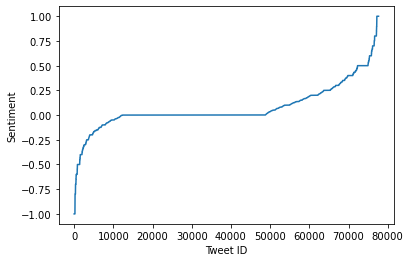

In [94]:
plt.plot(df_sentiment[['sentiment']])
plt.xlabel('Tweet ID')
plt.ylabel('Sentiment')
plt.show()

Plot scores on donut chart:

In [109]:
n_very_neg = len(df_sentiment[df_sentiment['sentiment'] < -0.25])
n_neg = len(df_sentiment[(df_sentiment['sentiment'] < 0) & (df_sentiment['sentiment'] > -0.25)])
n_neut = len(df_sentiment[df_sentiment['sentiment'] == 0])
n_pos = len(df_sentiment[(df_sentiment['sentiment'] > 0) & (df_sentiment['sentiment'] < 0.25)])
n_very_pos = len(df_sentiment[df_sentiment['sentiment'] > 0.25])
n_groups = [n_very_neg, n_neg,n_neut,n_pos,n_very_pos]
names = ['very negative', 'negative', 'neutral', 'positive','very positive']

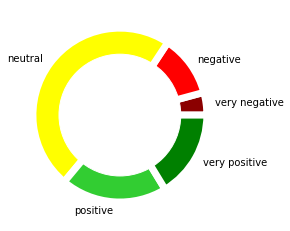

In [110]:
plt.pie(n_groups, labels=names, colors=['darkred','red','yellow','limegreen','green'],
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Get some descriptives:

In [111]:
df_neg = df_sentiment[df_sentiment['sentiment'] < 0]
df_pos = df_sentiment[df_sentiment['sentiment'] > 0]

print('mean score:')
print(df_sentiment['sentiment'].mean())

print('std:')
print(df_sentiment['sentiment'].std())

print('N negative:')
print(len(df_neg))

print('N positive:')
print(len(df_pos))

mean score:
0.07209058882973744
std:
0.22843928825378096
N negative:
12322
N positive:
28916


Extract the most common words found in both positive and negative positive reviews:

In [112]:
positive_words = pd.DataFrame(
    [dict(Counter(' '.join(df_pos['Text'].values.tolist()).split(' ')))]).T.sort_values(0, ascending=False)[0:100].index
negative_words = pd.DataFrame(
    [dict(Counter(' '.join(df_neg['Text'].values.tolist()).split(' ')))]).T.sort_values(0, ascending=False)[0:100].index

In [113]:
positive_words

Index(['bitcoin', 'crypto', 'btc', 'price', 'ftx', 'market', 'time', 'like',
       'eth', 'exchange', 'cryptocurrency', 'people', 'money', 'new', 'get',
       'news', 'one', 'buy', 'good', 'ethereum', 'blockchain', 'amp', 'year',
       'block', 'right', 'would', 'see', 'best', 'need', 'coin', 'make',
       'free', 'high', 'think', 'know', 'binance', 'first', 'still', 'many',
       'much', 'last', 'could', 'real', 'say', 'value', 'top', 'low', 'way',
       'latest', 'going', 'sat', 'want', 'world', 'day', 'even', 'nft',
       'thing', 'trading', 'wallet', 'better', 'use', 'great', 'nfts', 'worth',
       'gold', 'back', 'take', 'week', 'asset', 'xrp', 'network', 'never',
       'follow', 'also', 'cash', 'bnb', 'change', 'long', 'hold', 'tweet',
       'next', 'really', 'altcoin', 'lightning', 'hour', 'today', 'self',
       'currency', 'mining', 'trust', 'current', 'point', 'bank', 'let',
       'live', 'work', 'fiat', 'bottom', 'token', 'custody'],
      dtype='object')

In [114]:
negative_words

Index(['bitcoin', 'crypto', 'btc', 'price', 'ftx', 'eth', 'last', 'rsi',
       'ethereum', 'exchange', 'market', 'like', 'people', 'long', 'money',
       'time', 'average', 'one', 'cryptocurrency', 'year', 'lower', 'get',
       'moving', 'buy', 'indicator', 'need', 'upper', 'amp', 'bollinger',
       'week', 'bad', 'binance', 'say', 'make', 'think', 'cold', 'would',
       'coin', 'wallet', 'going', 'usdt', 'know', 'news', 'still', 'see',
       'day', 'take', 'even', 'blockchain', 'mean', 'fake', 'value', 'next',
       'way', 'thing', 'weekly', 'daily', 'could', 'scam', 'month', 'storage',
       'live', 'game', 'hard', 'asset', 'trust', 'shit', 'trading', 'every',
       'gold', 'wrong', 'back', 'worst', 'never', 'bank', 'mining', 'world',
       'want', 'saying', 'use', 'term', 'industry', 'change', 'also',
       'million', 'fund', 'currency', 'fiat', 'low', 'block', 'usd', 'nothing',
       'past', 'everyone', 'token', 'since', 'sat', 'new', 'hour', 'self'],
      dtype='objec

### 5. Conclusion

According to this analysis, with a mean sentiment of 0.07 (SD = 0.22) there is a slight but prevalent positive opinion in BTC tweets.

In [144]:
## Other function to clean the tweets
#def cleanTwt(twt):
#    twt = re.sub("#bitcoin", 'bitcoin', twt) # removes the '#' from bitcoin
#    twt = re.sub("#Bitcoin", 'Bitcoin', twt) # removes the '#' from Bitcoin
#    twt = re.sub('#[A-Za-z0-9]+', '', twt) # removes any string with a '#'
#    twt = re.sub('\\n', '', twt) # removes the '\n' string
#    twt = re.sub('https:\/\/\S+', '', twt) # removes any hyperlinks
#    return twt

In [145]:
#df["Text"] = df["Text"].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1 and s.find('www') == -1 and s.find('https') == -1]))
#df['cleaned_tweets'] = df['Text'].apply(cleanTwt)

,Text,cleaned_tweets
99991,"Hver watt som brukes på mining, er energi som ...","Hver watt som brukes på mining, er energi som ..."
99992,If you are/were and will be surprised about th...,If you are/were and will be surprised about th...
99993,🦄 Don’t Dream It’s Over 🦄\n✨ #Bitcoin #Ethereu...,🦄 Don’t Dream It’s Over 🦄✨ Bitcoin ✨
99994,Play brand new multi-coin game + free bitcoin ...,Play brand new multi-coin game + free bitcoin ...
99995,La casa de #crypto\nMoney Heist!\n#FTX #Binanc...,La casa de Money Heist! Bitcoin
99996,yes exactly because it broke down its higher h...,yes exactly because it broke down its higher h...
99997,don’t understand what bitcoiners are celebrati...,don’t understand what bitcoiners are celebrati...
99998,"Das Blockchain Trilemma! Dezentralität, Skalie...","Das Blockchain Trilemma! Dezentralität, Skalie..."
99999,Bitcoin prostě není možné vypnout. Smiřte se s...,Bitcoin prostě není možné vypnout. Smiřte se s...
100000,"Bitcoin is only the first. That’s all , it’s n...","Bitcoin is only the first. That’s all , it’s n..."


In [ ]:
#detect_langs(DF2.loc[3, "cleaned_tweets"])